In [ ]:
import pandas as pd
import numpy as np

import re
import nltk
import html
import string


from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score, ConfusionMatrixDisplay

from transformers import pipeline
from transformers import BertTokenizer, BertModel
from transformers import XLNetTokenizer, XLNetModel
import torch
import gensim

from tqdm import tqdm
import optuna

from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

import spacy
from nltk.corpus import stopwords
from nltk import PorterStemmer, WordNetLemmatizer

from gensim.models import Word2Vec
from imblearn.over_sampling import RandomOverSampler, ADASYN


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
plt.style.use('ggplot')

2024-04-30 16:16:04.050019: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 16:16:04.050201: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 16:16:04.212490: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
%matplotlib inline

In [ ]:
df = pd.read_csv("/kaggle/input/kuc-hackathon-winter-2018/drugsComTrain_raw.csv")
test = pd.read_csv('/kaggle/input/kuc-hackathon-winter-2018/drugsComTest_raw.csv')


In [ ]:
df_train_dl = pd.read_csv('/kaggle/input/drug-adr11/drugLibTrain_raw.tsv', sep="\t", index_col=0).dropna()
df_test_dl = pd.read_csv('/kaggle/input/drug-adr11/drugLibTest_raw.tsv', sep="\t", index_col=0).dropna()

In [ ]:
def classes_def(x):
    if x <= 4:
        return 0
    elif x >= 7:
        return 2
    else:
        return 1
    

df['label']=df['rating'].apply(lambda x:classes_def(x))
test['label']=test['rating'].apply(lambda x:classes_def(x))


In [6]:
y_train = df.label
y_test = test.label

In [7]:
df_train_dl['full_rev'] = df_train_dl['benefitsReview'] + df_train_dl['sideEffectsReview'] + df_train_dl['commentsReview']
df_test_dl['full_rev'] = df_test_dl['benefitsReview'] + df_test_dl['sideEffectsReview'] + df_test_dl['commentsReview']


In [8]:

X_rating_train = df_train_dl['commentsReview']
X_rating_test = df_test_dl['commentsReview']

y_rating_train = df_train_dl['rating']
y_rating_test = df_test_dl['rating']


y_rating_train=y_rating_train.apply(lambda x:classes_def(x))
y_rating_test=y_rating_test.apply(lambda x:classes_def(x))

X_benefitsReview_train = df_train_dl.benefitsReview
X_benefitsReview_test = df_test_dl.benefitsReview

y_benefitsReview_train = df_train_dl.effectiveness
y_benefitsReview_test = df_test_dl.effectiveness


X_sideEffects_train = df_train_dl.sideEffectsReview
X_sideEffects_test = df_test_dl.sideEffectsReview

y_sideEffects_train = df_train_dl.sideEffects
y_sideEffects_test = df_test_dl.sideEffects



X_full_rew_train = df_train_dl.full_rev
X_full_rew_test = df_test_dl.full_rev




In [9]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [10]:
from nltk.corpus import stopwords

In [11]:
stop_words = stopwords.words('english')


In [12]:
PUNCT_TO_REMOVE = string.punctuation

def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

from nltk.stem.porter import PorterStemmer


def stem_words(text):
    stemmer = PorterStemmer()
    return " ".join([stemmer.stem(word) for word in text.split()])

from nltk.stem import WordNetLemmatizer


from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])


def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)
def remove_html(text):
    text = html.unescape(text)
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)


In [13]:
def prep(text):
    text = text.str.lower()
    text = text.apply(remove_emoji)
    text = text.apply(remove_urls)
    text = text.apply(remove_html)

    text = text.apply(lambda t: remove_punctuation(t))
    text = text.apply(lambda t: lemmatize_words(t))
    text = text.apply(lambda t: remove_stopwords(t))

    return text


In [14]:
X_rating_train = prep(X_rating_train)
X_rating_test = prep(X_rating_test)

X_benefitsReview_train = prep(X_benefitsReview_train)
X_benefitsReview_test = prep(X_benefitsReview_test) 

X_sideEffects_train = prep(X_sideEffects_train)
X_sideEffects_test = prep(X_sideEffects_test)



In [15]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")
model = AutoModel.from_pretrained("medicalai/ClinicalBERT")



tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/542M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [16]:
gpu_num = 0
device = torch.device(f'cuda:{gpu_num}' if torch.cuda.is_available() else 'cpu')



def get_emdeddings(model, train, test, tokenizer, max_length=512):
    
        
        tokenized_texts = train.apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=max_length, truncation=True)).values
        max_len = max(len(text) for text in tokenized_texts)
        padded_texts = torch.tensor([text + [0] * (max_len - len(text)) for text in tokenized_texts])
        attention_mask = torch.where(padded_texts > 0, 1, 0)
        
        model.to(device)
        batch_size = 16
        
        features = []
        with torch.no_grad():
            for i in tqdm(range(0, len(padded_texts), batch_size)):
                texts_batch = padded_texts[i : i + batch_size].to(device)
                mask_batch = attention_mask[i : i + batch_size].to(device)
                output = model(texts_batch, mask_batch)
                batch_features = output.last_hidden_state[:, 0, :].cpu().numpy()
                features.append(batch_features)

        features = np.concatenate(features, axis=0)

        

        tokenized_texts_test = test.apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=max_length, truncation=True)).values
        max_len_test = max(len(text) for text in tokenized_texts_test)
        padded_texts_test = torch.tensor([text + [0] * (max_len_test - len(text)) for text in tokenized_texts_test])
        attention_mask_test = torch.where(padded_texts_test > 0, 1, 0)

        features_test = []
        with torch.no_grad():
            for i in tqdm(range(0, len(padded_texts_test), batch_size)):
                texts_batch_test = padded_texts_test[i : i + batch_size].to(device)
                mask_batch_test = attention_mask_test[i : i + batch_size].to(device)
                output_test = model(texts_batch_test, mask_batch_test)
                batch_features_test = output_test.last_hidden_state[:, 0, :].cpu().numpy()
                features_test.append(batch_features_test)

        features_test = np.concatenate(features_test, axis=0)

        return features, features_test

In [17]:
from sklearn.decomposition import NMF

def get_nmf(train, test,n_components=20 ):
    nmf = NMF(n_components=n_components, random_state=42)
    vectorizer = CountVectorizer(max_df=0.8, min_df=10, stop_words='english')
    train = vectorizer.fit_transform(train)
    test = vectorizer.transform(test)
    
    nmf.fit(train)
    nmf_features_train = nmf.transform(train)
    nmf_features_test = nmf.transform(test)
    
    return nmf_features_train, nmf_features_test

In [18]:
 side_train_bert, side_test_bert = get_emdeddings(model,X_sideEffects_train, X_sideEffects_test, tokenizer)

100%|██████████| 63/63 [03:44<00:00,  3.57s/it]


In [19]:
side_train_nmf, side_test_nmf = get_nmf(X_sideEffects_train, X_sideEffects_test)

In [20]:
train_lda_bert = np.concatenate((side_train_bert, side_train_nmf), axis=1)
test_lda_bert = np.concatenate((side_test_bert, side_test_nmf), axis=1)

## bert  Side eff

In [21]:
y_sideEffects_train = y_sideEffects_train.replace({'Extremely Severe Side Effects': 'Severe', 'Severe Side Effects': 'Severe',
        'Mild Side Effects': 'Moderate', 'Moderate Side Effects': 'Moderate' })

y_sideEffects_test = y_sideEffects_test.replace({'Extremely Severe Side Effects': 'Severe', 'Severe Side Effects': 'Severe',
        'Mild Side Effects': 'Moderate', 'Moderate Side Effects': 'Moderate' })


model = CatBoostClassifier(verbose=200, iterations=1000, random_state=20, auto_class_weights='Balanced')

model.fit(side_train_bert, y_sideEffects_train)

preds = model.predict(side_test_bert)
print(classification_report(y_sideEffects_test, preds))

Learning rate set to 0.083695
0:	learn: 1.0655626	total: 489ms	remaining: 8m 8s
200:	learn: 0.3834189	total: 52.6s	remaining: 3m 29s
400:	learn: 0.2269415	total: 1m 43s	remaining: 2m 34s
600:	learn: 0.1547040	total: 2m 34s	remaining: 1m 42s
800:	learn: 0.1169835	total: 3m 24s	remaining: 50.8s
999:	learn: 0.0956881	total: 4m 14s	remaining: 0us
                 precision    recall  f1-score   support

       Moderate       0.71      0.79      0.75       565
No Side Effects       0.76      0.66      0.71       244
         Severe       0.56      0.46      0.51       198

       accuracy                           0.70      1007
      macro avg       0.68      0.64      0.66      1007
   weighted avg       0.69      0.70      0.69      1007



In [22]:
y_sideEffects_train.value_counts()

sideEffects
Moderate           1622
No Side Effects     854
Severe              530
Name: count, dtype: int64

## bert + nmf  Side eff

In [23]:
model = CatBoostClassifier(verbose=200, iterations=1000, random_state=20, auto_class_weights='Balanced')

model.fit(train_lda_bert, y_sideEffects_train)

preds = model.predict(test_lda_bert)
print(classification_report(y_sideEffects_test, preds))

Learning rate set to 0.083695
0:	learn: 1.0663265	total: 417ms	remaining: 6m 57s
200:	learn: 0.3762038	total: 54s	remaining: 3m 34s
400:	learn: 0.2220311	total: 1m 46s	remaining: 2m 39s
600:	learn: 0.1504116	total: 2m 38s	remaining: 1m 45s
800:	learn: 0.1157672	total: 3m 30s	remaining: 52.2s
999:	learn: 0.0952280	total: 4m 21s	remaining: 0us
                 precision    recall  f1-score   support

       Moderate       0.74      0.82      0.77       565
No Side Effects       0.78      0.70      0.74       244
         Severe       0.62      0.51      0.56       198

       accuracy                           0.73      1007
      macro avg       0.71      0.68      0.69      1007
   weighted avg       0.72      0.73      0.72      1007



In [24]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score, ConfusionMatrixDisplay


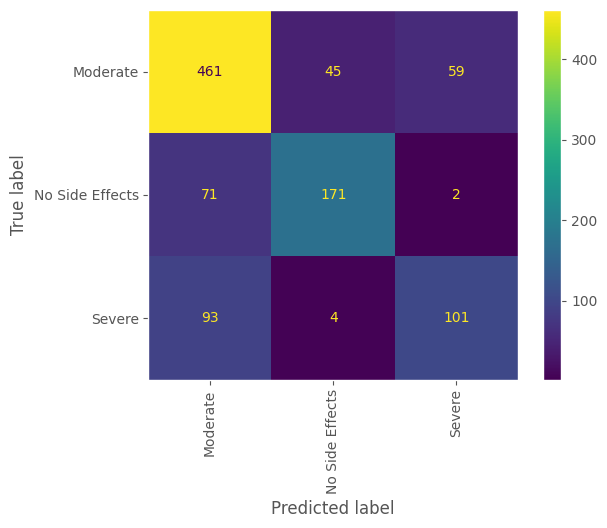

In [25]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_sideEffects_test, preds), display_labels = ['Moderate', 'No Side Effects', 'Severe'])
cm_display.plot(values_format = '.0f', ax=plt.gca(), xticks_rotation='vertical')

plt.grid(False)
plt.show()


In [26]:
y_benefitsReview_train = y_benefitsReview_train.replace({'Considerably Effective':'Considerably', 'Highly Effective':'Considerably',
        'Marginally Effective': 'Marginally', 'Moderately Effective': 'Marginally'})


y_benefitsReview_test = y_benefitsReview_test.replace({'Considerably Effective':'Considerably', 'Highly Effective':'Considerably',
        'Marginally Effective': 'Marginally', 'Moderately Effective': 'Marginally'})



In [27]:
y_benefitsReview_train.value_counts()

effectiveness
Considerably    2188
Marginally       587
Ineffective      231
Name: count, dtype: int64

In [28]:
tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")
model = AutoModel.from_pretrained("medicalai/ClinicalBERT")


In [29]:
benef_train_bert, benef_test_bert = get_emdeddings(model,X_benefitsReview_train, X_benefitsReview_test, tokenizer)

100%|██████████| 63/63 [03:29<00:00,  3.32s/it]


In [30]:
benef_train_nmf, benef_test_nmf = get_nmf(X_benefitsReview_train, X_benefitsReview_test, 10)

In [31]:
train_lda_bert_benef = np.concatenate((benef_train_bert, benef_train_nmf), axis=1)
test_lda_bert_benef = np.concatenate((benef_test_bert, benef_test_nmf), axis=1)

## bert benef

In [32]:
model = CatBoostClassifier(verbose=200, iterations=1000, random_state=20)
# model = LGBMClassifier( random_state=20)

model.fit(benef_train_bert, y_benefitsReview_train)

preds = model.predict(benef_test_bert)
print(classification_report(y_benefitsReview_test, preds))

Learning rate set to 0.083695
0:	learn: 1.0381660	total: 566ms	remaining: 9m 25s
200:	learn: 0.3738811	total: 54.6s	remaining: 3m 37s
400:	learn: 0.2227929	total: 1m 48s	remaining: 2m 42s
600:	learn: 0.1448228	total: 2m 43s	remaining: 1m 48s
800:	learn: 0.1027454	total: 3m 37s	remaining: 54s
999:	learn: 0.0791012	total: 4m 31s	remaining: 0us
              precision    recall  f1-score   support

Considerably       0.74      0.97      0.84       699
 Ineffective       0.91      0.37      0.53        78
  Marginally       0.58      0.13      0.21       230

    accuracy                           0.73      1007
   macro avg       0.74      0.49      0.52      1007
weighted avg       0.71      0.73      0.67      1007



## bert + nmf benef

In [33]:
model = CatBoostClassifier(verbose=200, iterations=1000, random_state=20, auto_class_weights='Balanced')

model.fit(train_lda_bert_benef, y_benefitsReview_train)

preds = model.predict(test_lda_bert_benef)
print(classification_report(y_benefitsReview_test, preds))

Learning rate set to 0.083695
0:	learn: 1.0825811	total: 464ms	remaining: 7m 43s
200:	learn: 0.3813475	total: 56.1s	remaining: 3m 42s
400:	learn: 0.1969342	total: 1m 50s	remaining: 2m 45s
600:	learn: 0.1224767	total: 2m 45s	remaining: 1m 50s
800:	learn: 0.0871478	total: 3m 40s	remaining: 54.8s
999:	learn: 0.0673527	total: 4m 35s	remaining: 0us
              precision    recall  f1-score   support

Considerably       0.75      0.94      0.83       699
 Ineffective       0.74      0.44      0.55        78
  Marginally       0.47      0.16      0.24       230

    accuracy                           0.72      1007
   macro avg       0.65      0.51      0.54      1007
weighted avg       0.68      0.72      0.68      1007



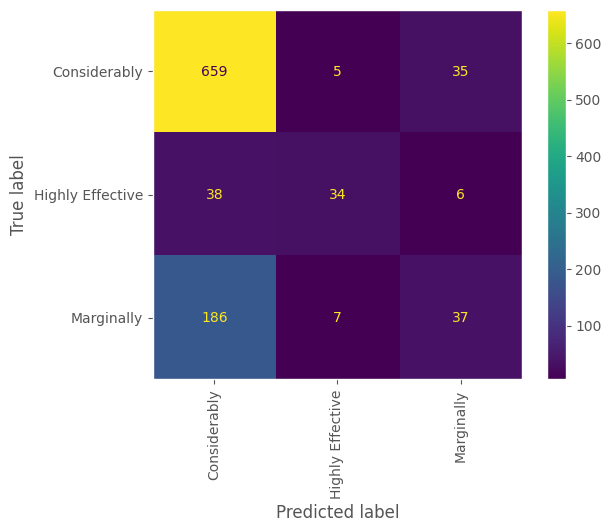

In [34]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_benefitsReview_test, preds), display_labels = ['Considerably', 'Highly Effective', 'Marginally'])
cm_display.plot(values_format = '.0f', ax=plt.gca(), xticks_rotation='vertical')

plt.grid(False)
plt.show()



## Bow side eff


In [64]:
side_train_nmf, side_test_nmf = get_nmf(X_sideEffects_train, X_sideEffects_test)

In [65]:
vectorizer = CountVectorizer(max_df=0.5, min_df=10)
X_train = vectorizer.fit_transform(X_sideEffects_train)

X_test = vectorizer.transform(X_sideEffects_test)

cb = CatBoostClassifier(verbose=400, random_state=1)
cb.fit(X_train, y_sideEffects_train)

y_pred = cb.predict(X_test)

Learning rate set to 0.083695
0:	learn: 1.0548495	total: 11.5ms	remaining: 11.4s
400:	learn: 0.4902107	total: 4.04s	remaining: 6.04s
800:	learn: 0.4066332	total: 7.88s	remaining: 1.96s
999:	learn: 0.3763006	total: 9.63s	remaining: 0us


In [66]:
print(classification_report(y_sideEffects_test, y_pred, ),)
print(f1_score(y_sideEffects_test, y_pred, average='micro'),)


                 precision    recall  f1-score   support

       Moderate       0.74      0.87      0.80       565
No Side Effects       0.79      0.74      0.76       244
         Severe       0.72      0.42      0.53       198

       accuracy                           0.75      1007
      macro avg       0.75      0.68      0.70      1007
   weighted avg       0.75      0.75      0.74      1007

0.7507447864945381


## Bow  + nmf side eff

In [67]:
vectorizer = CountVectorizer(max_df=0.5, min_df=10)
X_train = vectorizer.fit_transform(X_sideEffects_train)
X_train = np.concatenate(((X_train).toarray(), side_train_nmf), axis=1)

X_test = vectorizer.transform(X_sideEffects_test)
X_test = np.concatenate((X_test.toarray(), side_test_nmf), axis=1)

cb = CatBoostClassifier(verbose=400, random_state=1)
cb.fit(X_train, y_sideEffects_train)

y_pred = cb.predict(X_test)



Learning rate set to 0.083695
0:	learn: 1.0505615	total: 25.3ms	remaining: 25.3s
400:	learn: 0.4363300	total: 6.58s	remaining: 9.83s
800:	learn: 0.3302768	total: 13.3s	remaining: 3.3s
999:	learn: 0.2967110	total: 16.6s	remaining: 0us


In [68]:
print(classification_report(y_sideEffects_test, y_pred))
print(f1_score(y_sideEffects_test, y_pred, average='micro'),)


                 precision    recall  f1-score   support

       Moderate       0.76      0.87      0.81       565
No Side Effects       0.80      0.74      0.77       244
         Severe       0.74      0.48      0.58       198

       accuracy                           0.76      1007
      macro avg       0.76      0.70      0.72      1007
   weighted avg       0.76      0.76      0.76      1007

0.7646474677259185


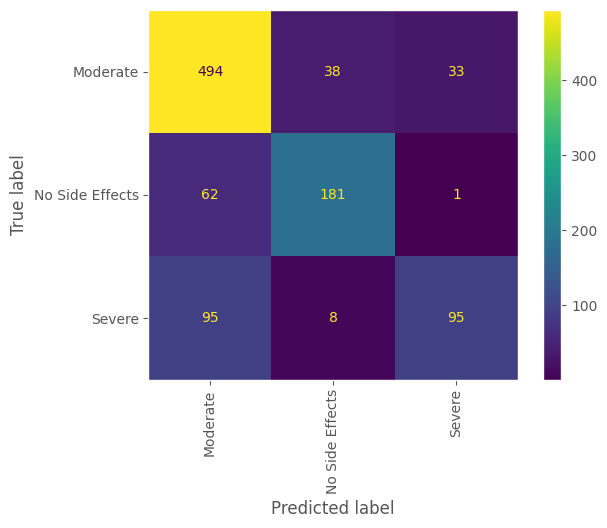

In [69]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_sideEffects_test, y_pred), display_labels = ['Moderate', 'No Side Effects', 'Severe'])
cm_display.plot(values_format = '.0f', ax=plt.gca(), xticks_rotation='vertical')

plt.grid(False)
plt.show()


### Важные слова

In [84]:
nmf = NMF(n_components=10, random_state=42)
vectorizer = CountVectorizer(max_df=0.5, min_df=10)
train = vectorizer.fit_transform(X_sideEffects_train)
test = vectorizer.transform(X_sideEffects_test)
    
nmf.fit(train)

    
    
# Вычисляем веса для каждого слова в каждом отзыве
word_weights = nmf.transform(test)

top_words_indices_per_review = [review_weights.argsort()[-5:][::-1] for review_weights in word_weights]

# Получаем список слов из векторизатора
feature_names = vectorizer.get_feature_names_out()



# indices_of_interest = [141, 144, 145, 147, 153]

for i, (review_indices, label, pred) in enumerate(zip(top_words_indices_per_review, y_sideEffects_test, preds)):
    if label != 'No Side Effects' and pred != 'No Side Effects' and i > 1 and i<100:
        review_words = X_sideEffects_test.iloc[i].split()  # Получаем список слов для текущего отзыва
        top_words = [review_words[idx] for idx in review_indices if idx < len(review_words)]
        print(f"Отзыв: {X_sideEffects_test.iloc[i]}")
        print(f" Важные слова: {', '.join(top_words)} (Класс: {label})")
        print('--------')


Отзыв: depakene thin coating cause severe heart burn stomach upset discomfort unpleasant make want take med take consistently prescribe caused mood fluctuate even switch depakote stomach still uncomfortable several week afterwards appetite decrease food unappetizing certain food normally enjoy chicken fish make feel extremely queasy eat like physical side effect drug decide quit psychiatric drug altogether longer stable anymore
 Важные слова: stomach, depakene, thin, upset, severe (Класс: Severe)
--------
Отзыв: side effect include moderate severe dry skin condition rectify topical application aquafore moisturizer
 Важные слова: moderate, effect, severe, topical, rectify (Класс: Moderate)
--------
Отзыв: tiredsleepy tired sleep tired tired sometimes time less tired im sorry say 50 word blah blah see see see see see
 Важные слова: sleep, sometimes, tired, time, tired (Класс: Moderate)
--------
Отзыв: side effect far hope stay way
 Важные слова: effect (Класс: Moderate)
--------
Отзыв: g

## Bow benef

In [71]:
ben_train_nmf, ben_test_nmf = get_nmf(X_benefitsReview_train, X_benefitsReview_test)

In [72]:
vectorizer = CountVectorizer(max_df=0.5, min_df=10)
X_train = vectorizer.fit_transform(X_benefitsReview_train)

X_test = vectorizer.transform(X_benefitsReview_test)

cb = CatBoostClassifier(verbose=400, random_state=1)
cb.fit(X_train, y_benefitsReview_train)

y_pred = cb.predict(X_test)

Learning rate set to 0.083695
0:	learn: 1.0412486	total: 10.5ms	remaining: 10.4s
400:	learn: 0.4875398	total: 3.63s	remaining: 5.42s
800:	learn: 0.4144723	total: 7.66s	remaining: 1.9s
999:	learn: 0.3867438	total: 9.53s	remaining: 0us


In [73]:
print(classification_report(y_benefitsReview_test, y_pred, ),)
print(f1_score(y_benefitsReview_test, y_pred, average='micro'),)


              precision    recall  f1-score   support

Considerably       0.76      0.96      0.85       699
 Ineffective       0.72      0.50      0.59        78
  Marginally       0.56      0.15      0.23       230

    accuracy                           0.74      1007
   macro avg       0.68      0.54      0.56      1007
weighted avg       0.71      0.74      0.69      1007

0.7418073485600795


## Bow + nmf benef

In [74]:
vectorizer = CountVectorizer(max_df=0.5, min_df=10)
X_train = vectorizer.fit_transform(X_benefitsReview_train)
X_train = np.concatenate(((X_train).toarray(), ben_train_nmf), axis=1)

X_test = vectorizer.transform(X_benefitsReview_test)
X_test = np.concatenate(((X_test).toarray(), ben_test_nmf), axis=1)

cb = CatBoostClassifier(verbose=400, random_state=1)
cb.fit(X_train, y_benefitsReview_train)

y_pred = cb.predict(X_test)

Learning rate set to 0.083695
0:	learn: 1.0412726	total: 26ms	remaining: 26s
400:	learn: 0.4366250	total: 6.9s	remaining: 10.3s
800:	learn: 0.3426075	total: 13.6s	remaining: 3.38s
999:	learn: 0.3072123	total: 16.9s	remaining: 0us


In [75]:
print(classification_report(y_benefitsReview_test, y_pred, ),)
print(f1_score(y_benefitsReview_test, y_pred, average='micro'),)


              precision    recall  f1-score   support

Considerably       0.75      0.97      0.85       699
 Ineffective       0.73      0.46      0.57        78
  Marginally       0.61      0.15      0.24       230

    accuracy                           0.74      1007
   macro avg       0.70      0.53      0.55      1007
weighted avg       0.72      0.74      0.69      1007

0.743793445878848


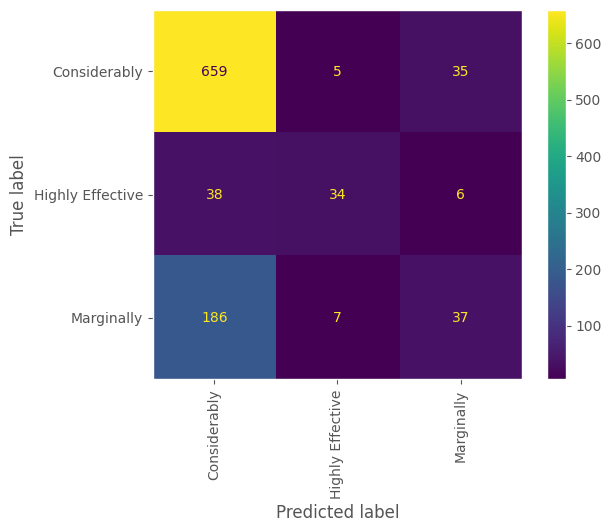

In [76]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_benefitsReview_test, preds), display_labels = ['Considerably', 'Highly Effective', 'Marginally'])
cm_display.plot(values_format = '.0f', ax=plt.gca(), xticks_rotation='vertical')

plt.grid(False)
plt.show()


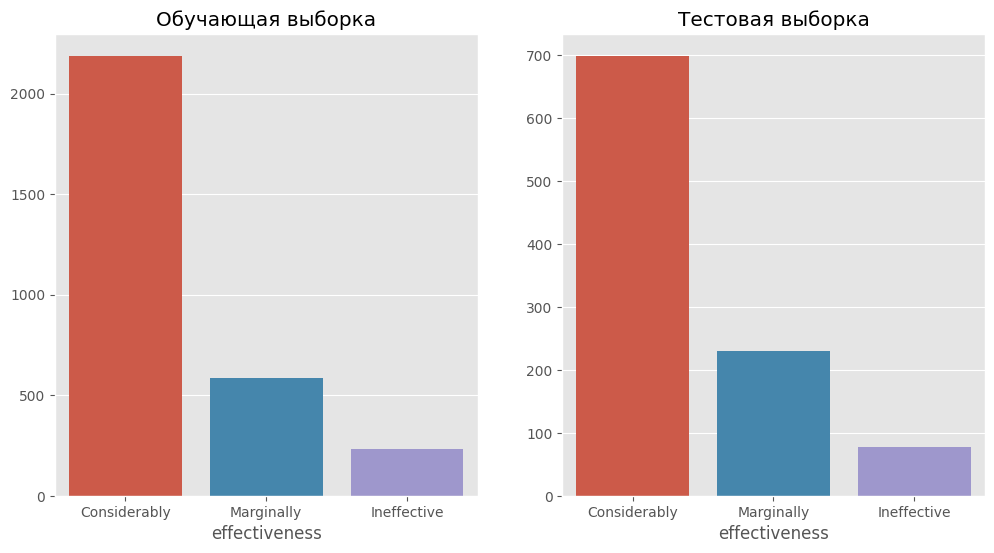

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))


counts_train = y_benefitsReview_train.value_counts()
sns.barplot(x=counts_train.index, y=counts_train.values, ax=axs[0])
axs[0].set_title('Обучающая выборка')

counts = y_benefitsReview_test.value_counts()
sns.barplot(x=counts.index, y=counts.values, ax=axs[1])
axs[1].set_title('Тестовая выборка')

plt.show()



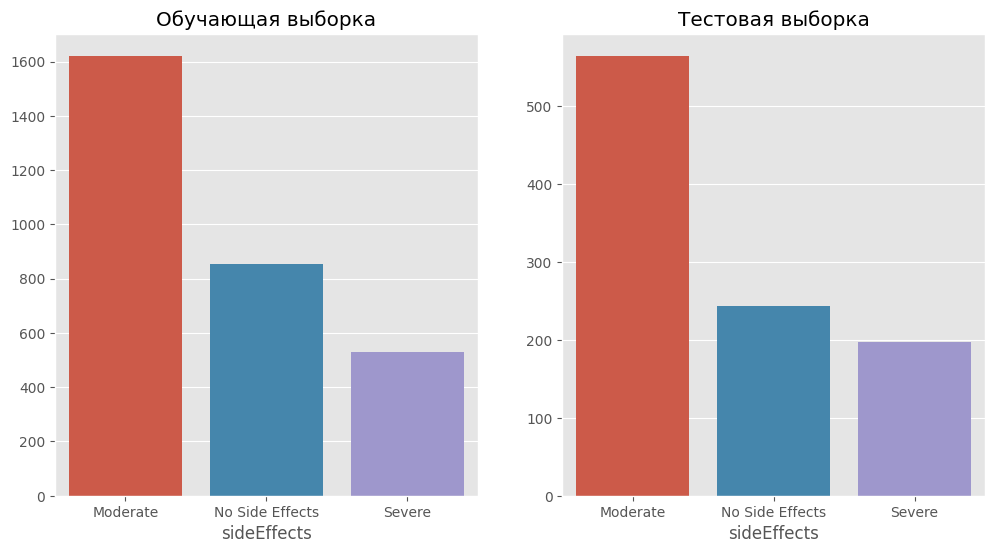

In [78]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))


counts_train = y_sideEffects_train.value_counts()
sns.barplot(x=counts_train.index, y=counts_train.values, ax=axs[0])
axs[0].set_title('Обучающая выборка')

counts = y_sideEffects_test.value_counts()
sns.barplot(x=counts.index, y=counts.values, ax=axs[1])
axs[1].set_title('Тестовая выборка')

plt.show()
